# Self-organized criticality

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell1D.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

Downloaded utils.py
Downloaded Cell1D.py
Downloaded Cell2D.py


In [9]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

def draw_array(array, **options):
    """Draws the cells."""
    n, m = array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1,
                        interpolation='none',
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    return plt.imshow(array, **options)

# Percolation

In the percolation model, each cell is porous with probability `p`.  We start with a row of wet cells at the top.  **During each time step, a cell becomes wet if it is porous and at least one neighbor is wet (using a 4-cell neighborhood).**  For each value of `p` we compute the probability that water reaches the bottom row.

**If there is a path of wet cells from the top to the bottom row, we say that the CA has a “percolating cluster”.**

Porous cells have state `1` and wet cells have state `5`, so **if a cell has a wet neighbor, the sum of the neighbors will be `5` or more.**


[`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html): choose 1 (porous) with probability `q`, and 0 (non-porous) with probability `1-q`.

This kernel defines a 4-cell “von Neumann” neighborhood; unlike the Moore neighborhood we saw in Section 6.1, it does not include the diagonals.

In [11]:
from scipy.signal import correlate2d
from Cell2D import Cell2D
from utils import three_frame, underride



class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    # 4-cell neighborhood
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, q=0.5):
        """Initializes the attributes.

        n: number of rows
        q: probability of porousness
        """
        self.q = q
        self.array = np.random.choice([1, 0], (n, n), p=[q, 1-q])  # initialize the porous and non-porous cells
        self.array[0] = 5  # fill the top row with wet cells

    def step(self):
        """Executes one time step."""
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5   # if the cell is porous and has at least one wet neighbor, update to wet cell.

    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)

    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Blues', vmax=5)

Here an example that shows the first three time steps.

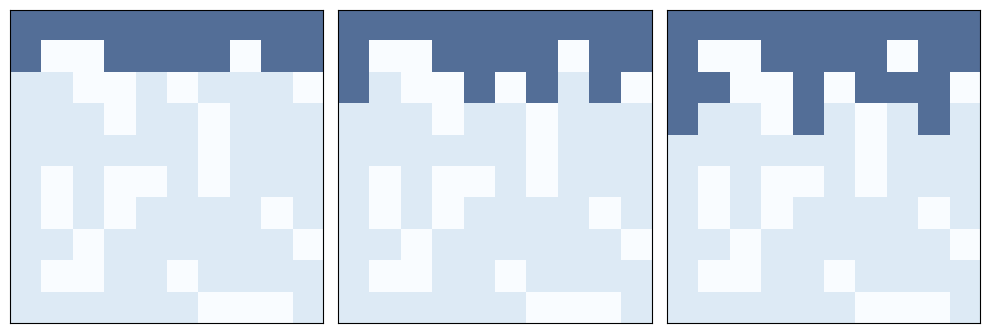

In [13]:
n = 10
q = 0.7
np.random.seed(18)
perc = Percolation(n, q)

three_frame(perc, [1, 1, 1])

`test_perc` runs a percolation model and returns `True` if water reaches the bottom row and `False` otherwise.

In [14]:
def test_perc(perc):
    """Run a percolation model.

    Runs until water gets to the bottom row or nothing changes.

    returns: boolean, whether there's a percolating cluster
    """
    num_wet = perc.num_wet()

    while True:
        perc.step() # update the wet cells over steps.

        if perc.bottom_row_wet(): # cells updated over steps, until the bottom row has wet cells.
            return True           # then, there should be a path of wet cells from top to bottom.

        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:  # if total number of wet cells should increase over steps.
            return False            # if the cell number stops increasing, then it reaches to a fixed state point before
                                    # returing True for percolating cluster.
        num_wet = new_num_wet

Run a small example.

In [15]:
np.random.seed(18)
perc = Percolation(n, q)
test_perc(perc)

True

And here's the animation

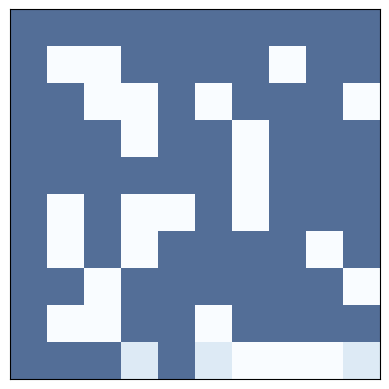

In [16]:
np.random.seed(18)
perc = Percolation(n, q)
perc.animate(frames=12, interval=0.3)

For a given `q` we can estimate the probability of a percolating cluster by running several random configurations.

`estimate_prob_percolating` makes 100 Percolation objects with the given values of n and q and calls test_perc to see **how many of them have a percolating cluster.**

In [17]:
def estimate_prob_percolating(n=100, q=0.5, iters=100):
    """Estimates the probability of percolating.

    n: int number of rows and columns
    q: probability that a cell is permeable
    iters: number of arrays to test

    returns: float probability
    """
    t = [test_perc(Percolation(n, q)) for i in range(iters)]
    return np.mean(t)

At `q=0.55` the probability is low.

In [18]:
fraction = estimate_prob_percolating(q=0.55)
print(fraction)

0.0


At `q=0.6`, the probability is close to 50%, which suggests that the critical value is nearby.

In [19]:
fraction = estimate_prob_percolating(q=0.6)
print(fraction)

0.71


At `p=0.65` the probability is high.

In [20]:
fraction = estimate_prob_percolating(q=0.65)
print(fraction)

1.0


We can search for the critical value by random walk: if there's a percolating cluster, we decrease `q`; otherwise we increase it.

The path should go to the critical point and wander around it.

In [21]:
def find_critical(n=100, q=0.6, iters=100):
    """Estimate q_crit by random walk.

    returns: list of q that should wander around q_crit
    """
    qs = [q]
    for i in range(iters):
        perc = Percolation(n, q)
        if test_perc(perc):
            q -= 0.005
        else:
            q += 0.005
        qs.append(q)
    return qs

Let's see whether the critical value depends on the size of the grid.

With `n=50`, the random walk wanders around 0.59.

CPU times: user 11 s, sys: 33.5 ms, total: 11 s
Wall time: 11.2 s


0.5932367632367631

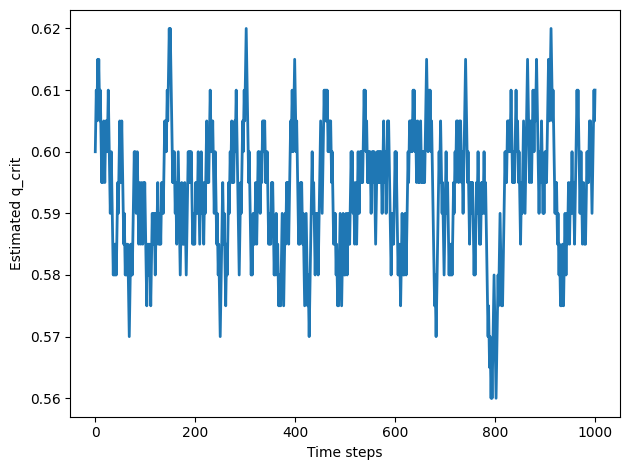

In [22]:
%time qs = find_critical(n=50, iters=1000)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Larger values of `n` don't seem to change the critical value.

CPU times: user 16.5 s, sys: 42.9 ms, total: 16.5 s
Wall time: 16.6 s


0.5933830845771144

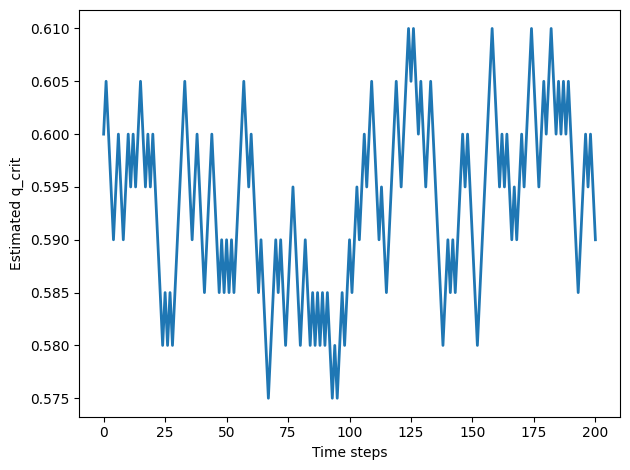

In [23]:
%time qs = find_critical(n=100, iters=200)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

CPU times: user 27.4 s, sys: 61.4 ms, total: 27.5 s
Wall time: 28 s


0.5912195121951219

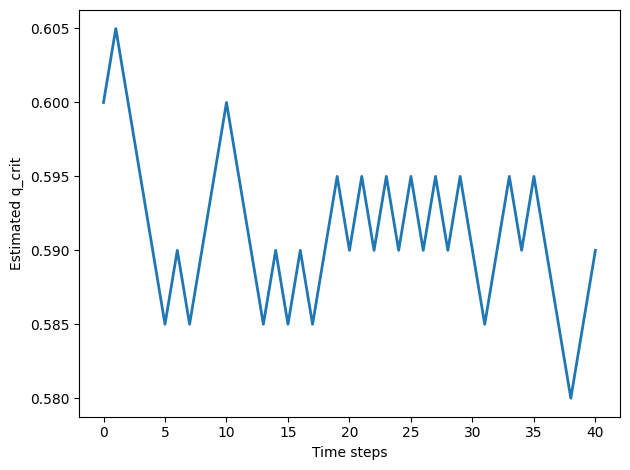

In [24]:
%time qs = find_critical(n=200, iters=40)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

CPU times: user 1min, sys: 193 ms, total: 1min 1s
Wall time: 1min 4s


0.5968181818181817

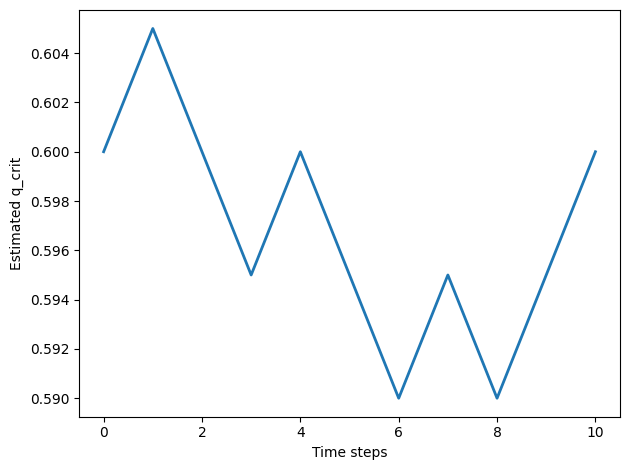

In [25]:
%time qs = find_critical(n=400, iters=10)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

# Sand pile

Here's an implementation of the sand pile model.

In [26]:
import itertools
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

class SandPile(Cell2D):
    """Diffusion Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]], dtype=np.int32)

    def __init__(self, n, m=None, level=9):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        level: starting value for all cells, greater than the critical value.
        """
        m = n if m is None else m
        self.array = np.ones((n, m), dtype=np.int32) * level
        self.toppled_seq = []

    def step(self, K=3):
        """Executes one time step.

        returns: number of cells that toppled
        """
        toppling = self.array > K
        num_toppled = np.sum(toppling)
        self.toppled_seq.append(num_toppled)

        c = correlate2d(toppling, self.kernel, mode='same')
        self.array += c
        return num_toppled

    def drop(self):
        """Increments a random cell."""
        a = self.array
        n, m = a.shape
        index = np.random.randint(n), np.random.randint(m)
        a[index] += 1

    def run(self):
        """Runs until equilibrium.

        returns: duration, total number of topplings
        """
        # itertools.count: an infinite generator that counts up from the given initial value
        total = 0
        for i in itertools.count(1):
            num_toppled = self.step()
            total += num_toppled
            if num_toppled == 0:
                return i, total

    def drop_and_run(self):
        """Drops a random grain and runs to equilibrium.

        returns: duration, total_toppled
        """
        self.drop()
        duration, total_toppled = self.run()
        return duration, total_toppled

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=5)

Here's a small example starting with two cells ready to topple.  `n` is the number of rows, `m` is the number of columns.

In [27]:
pile = SandPile(n=3, m=5, level=0)
pile.array[1, 1] = 4
pile.array[1, 3] = 4

a = pile.array
print(a)

[[0 0 0 0 0]
 [0 4 0 4 0]
 [0 0 0 0 0]]


To execute one step, first we find cells that are above the toppling threshold, `K`.

In [28]:
K = 3
toppling = a > K
print(toppling.astype(int))

[[0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]]


Then we use `correlate2d` to make a copy of the update kernel around each toppling cell.

In [29]:
kernel = np.array([[0, 1, 0],
                   [1,-4, 1],
                   [0, 1, 0]])
print(kernel)

[[ 0  1  0]
 [ 1 -4  1]
 [ 0  1  0]]


In [30]:
from scipy.signal import correlate2d

c = correlate2d(toppling, kernel, mode='same', boundary='fill', fillvalue=0)
print(c)

[[ 0  1  0  1  0]
 [ 1 -4  2 -4  1]
 [ 0  1  0  1  0]]


Finally, we add the result back into the array:

In [31]:
a += c
print(a)

[[0 1 0 1 0]
 [1 0 2 0 1]
 [0 1 0 1 0]]


Any grains that topple off the edge disappear.

## Animation

Let's look at a bigger pile, with `n=20`.  All cells are initialized to `level`, which is meant to be substantially bigger than `K`.

In [32]:
pile = SandPile(n=20, level=10)
print(pile.run())

(332, 53336)


The `run` function invokes `step` until no more cells topple and returns the number of time steps and the number of affected cells.

Here's what it looks like.  Starting with `level>K` produces all kinds of interesting patterns.

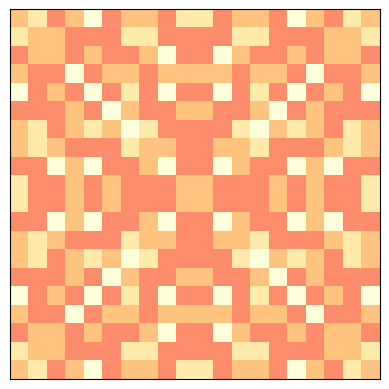

In [33]:
pile.draw()

Now let's look at an animation, starting from this initialized pile.

Each step of the animation drops a single grain at a random location and runs until no more cells topple.

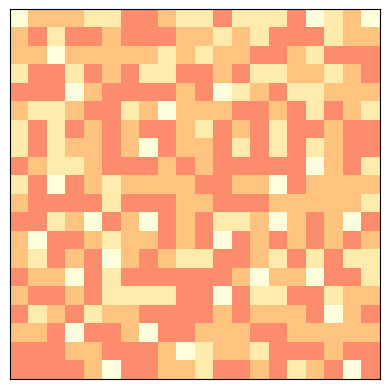

In [34]:
pile.animate(frames=100, step=pile.drop_and_run)

After a while, the pile looks pretty random.

Here's a plot of the number of cells toppled after each `step`.  

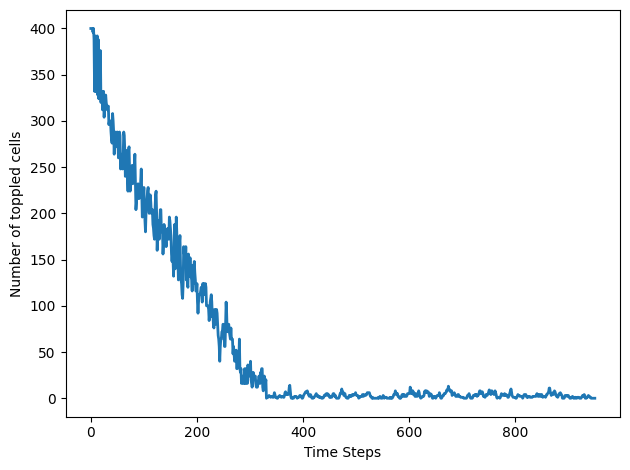

In [35]:
plt.plot(pile.toppled_seq)
decorate(xlabel='Time Steps', ylabel='Number of toppled cells')

The following figure shows the progression of the pile from ordered to apparently random.

(332, 53336)


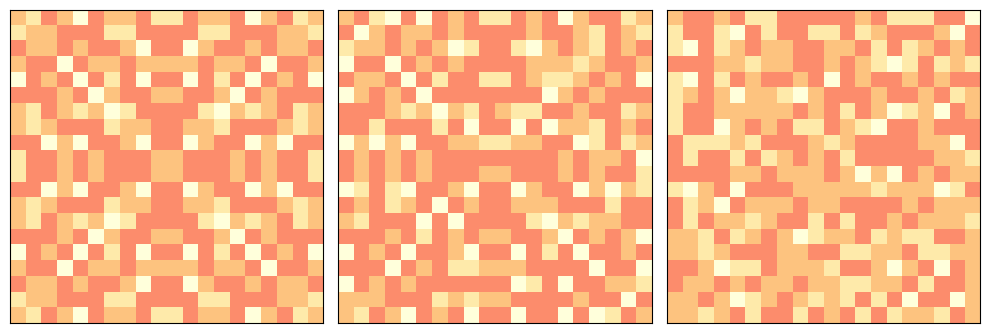

In [37]:
np.random.seed(17)

pile = SandPile(n=20, level=10)
print(pile.run())

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
pile.draw()

plt.subplot(1, 3, 2)
for i in range(20):
    pile.drop_and_run()
pile.draw()

plt.subplot(1, 3, 3)
for i in range(200):
    pile.drop_and_run()
pile.draw()

plt.tight_layout()

# Long tailed distributions

If the sand pile is in a critical state, we expect quantities like the duration of an avalanche, `T`, and the number of cells affected, `S`, to have long-tailed distributions.

Following Bak, Tang, and Wiesenseld, we start with a 50x50 array and plot the PMFs of `S` and `T` on a log-log scale.

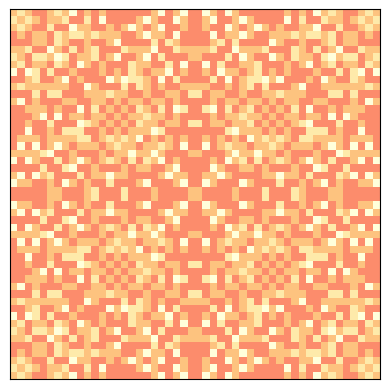

In [38]:
pile2 = SandPile(n=50, level=30)
pile2.run()
pile2.draw()

Now we run the pile for many time steps and keep track of the durations and number of cells affected.

In [39]:
np.random.seed(17)

iters = 100000
%time res = [pile2.drop_and_run() for _ in range(iters)]

CPU times: user 4min, sys: 3.93 s, total: 4min 4s
Wall time: 4min 4s


We can use `np.transpose` to extract the results as two NumPy arrays.

In [40]:
T, S = np.transpose(res)

A large majority of drops have duration 1 and no toppled cells.  If we filter them out, we get a clearer picture of the rest of the distribution.

In [41]:
T = T[T>1]
S = S[S>0]

We can use `Pmf` from the `empiricaldist` module to compute PMFs of `T` and `S`.

In [42]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.5-py3-none-any.whl size=12469 sha256=c09a2632cf7dba2d1008e93ca45a915908d9da575c5b615edf038175e62add6a
  Stored in directory: /root/.cache/pip/wheels/0d/d0/ae/1ad4c7593703e55b2321b23b49d3b0d55261b59d7036d7045b
Successfully built empiricaldist


In [43]:
from empiricaldist import Pmf

pmfT = Pmf.from_seq(T)
pmfS = Pmf.from_seq(S)

The distributions of `T` and `S` have many small values and a few very large ones.

Here are the PMFs on linear axes (showing values up to 50).

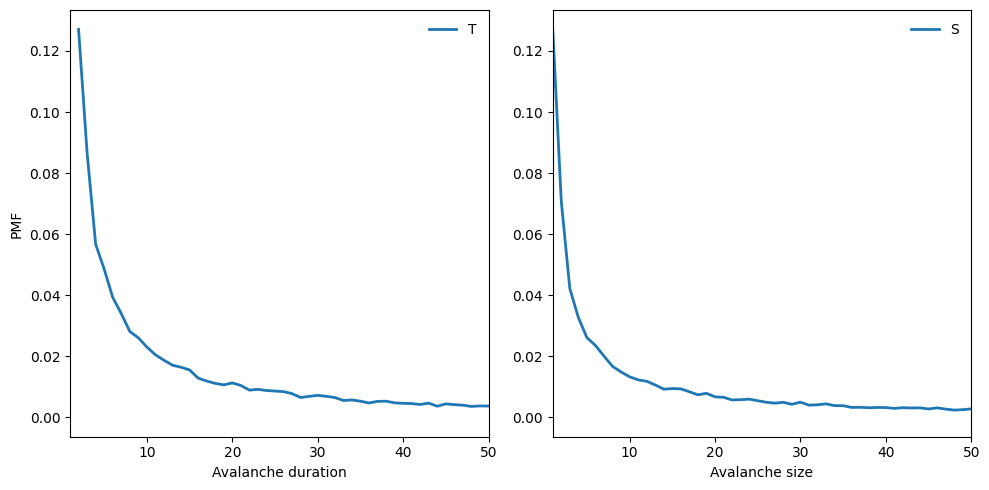

In [45]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

pmfT.plot(label='T')
decorate(xlabel='Avalanche duration',
                 ylabel='PMF',
                 xlim=[1, 50], loc='upper right')

plt.subplot(1, 2, 2)
pmfS.plot(label='S')
decorate(xlabel='Avalanche size',
                 xlim=[1, 50])


To see whether these distributions follow a power law, we plot the PMFs on a log-log scale.

[-1.1188474]
[-1.01439469]


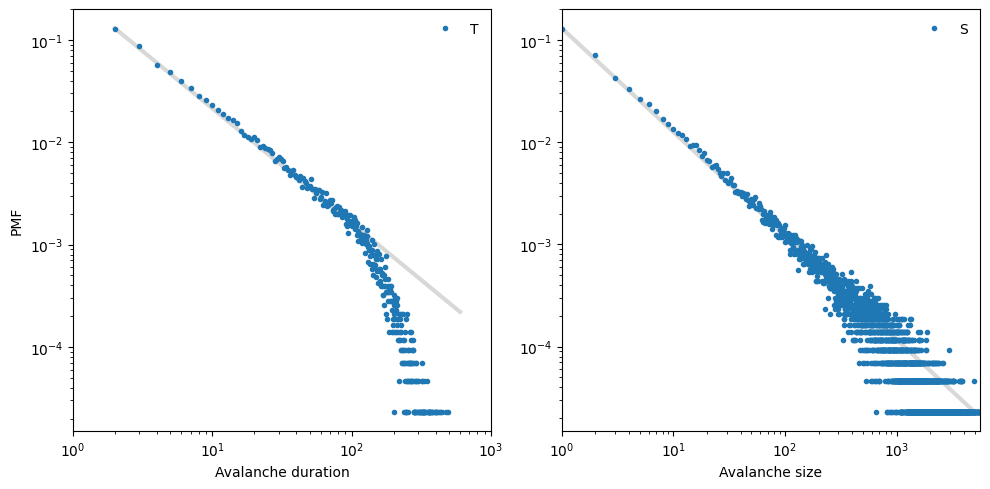

In [46]:
def slope(xs, ys):
    return np.diff(np.log(ys)) / np.diff(np.log(xs))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

xs = [2, 600]
ys = [1.3e-1, 2.2e-4]
print(slope(xs, ys))

options = dict(lw=3, color='gray', alpha=0.3)
plt.plot(xs, ys, **options)

pmfT.plot(lw=0, marker='.', label='T')
decorate(xlabel='Avalanche duration',
                 xlim=[1, 1000],
                 ylabel='PMF',
                 xscale='log',
                 yscale='log',
                 loc='upper right')

plt.subplot(1, 2, 2)

xs = [1, 5000]
ys = [1.3e-1, 2.3e-5]
print(slope(xs, ys))

plt.plot(xs, ys, **options)
pmfS.plot(lw=0, marker='.', label='S')
decorate(xlabel='Avalanche size',
                 xlim=[1, 5600],
                 xscale='log',
                 yscale='log')


The gray lines have slopes near -1.  The distribution of avalanche duration is approximately straight between 1 and 100, but then drops off.  The distribution of size follows a power law more closely and over a greater range, but it also seems to drop off for values above a few hundred.

# Fractals

If the sand pile is in a critical state, we expect to see fractal geometry.

To estimate the fractal dimension, I'll start with a bigger pile and a higher initial level.

In [47]:
pile3 = SandPile(n=131, level=22)
%time pile3.run()

CPU times: user 31.3 s, sys: 62.6 ms, total: 31.3 s
Wall time: 36.5 s


(28379, 211320220)

The initial state sure looks like a fractal.

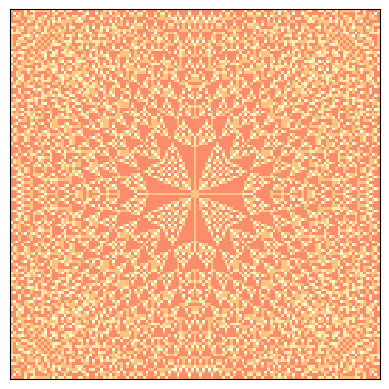

In [48]:
pile3.draw()

Since it contains four different levels (0, 1, 2, and 3), we can extract 4 binary patterns.

In [49]:
def draw_four(pile, levels=range(4)):
    plt.figure(figsize=(8, 8))
    for i, level in enumerate(levels):
        plt.subplot(2, 2, i+1)
        draw_array(pile.array==level, cmap='YlOrRd', vmax=1)

    plt.tight_layout()

Here's what they look like:

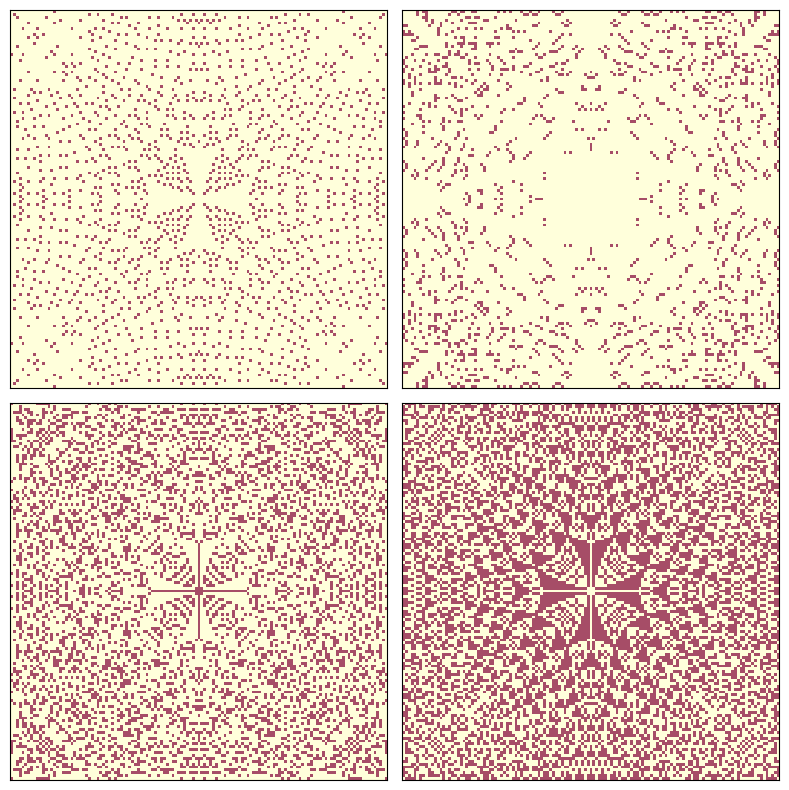

In [50]:
draw_four(pile3)

Now we can apply a box-counting algorithm to each level.

`count_cells` starts with a single cell in the middle, gradually increases the size of the box, and counts the number of cells in each box.

In [51]:
def count_cells(a):
    """Counts the number of cells in boxes with increasing size.

    a: NumPy array

    returns: list of (i, i**2, cell count) tuples
    """
    n, m = a.shape
    end = min(n, m)

    res = []
    for i in range(1, end, 2):
        top = (n-i) // 2
        left = (m-i) // 2
        box = a[top:top+i, left:left+i]
        total = np.sum(box)
        res.append((i, i**2, total))

    return np.transpose(res)

`box_count` takes a pile and a level, extracts the cells that have the given level, calls `count_cells`, and estimates the fractal dimension.

If `plot` is `True`, it also generates a graph of cell count versus box size on a log-log scale.

To estimate the slopes of these lines, we can use the SciPy function [linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html), which fits a line to the data by linear regression

In [52]:
from scipy.stats import linregress

def box_count(pile, level, plot=False):
    """Estimates the fractal dimension by box counting.

    pile: SandPile
    level: which level from the pile to count
    plot: boolean, whether to generate a plot

    returns: estimated fractal dimension
    """
    res = count_cells(pile.array==level)
    steps, steps2, cells = res

    # select the range where we have a nonzero number of cells
    legit = np.nonzero(cells)
    steps = steps[legit]
    steps2 = steps2[legit]
    cells = cells[legit]

    if plot:
        # only put labels on the left and bottom subplots
        xlabel = 'Box Size' if level in [2, 3] else ''
        ylabel = 'Cell Count' if level in [0, 2] else ''

        options = dict(linestyle='dashed', color='gray', alpha=0.7)
        plt.plot(steps, steps2, **options)
        plt.plot(steps, cells, label='level=%d' % level)
        plt.plot(steps, steps, **options)

        decorate(xscale='log', yscale='log',
                         xlim=[1, 200], loc='upper left',
                         xlabel=xlabel, ylabel=ylabel)
        #thinkplot.bigger_text()

    params = linregress(np.log(steps), np.log(cells))
    return params[0]

Finally `box_count_four` applies the box counting algorithm for each value in the sand pile.

In [53]:
def box_count_four(pile, levels=range(4)):
    """Applies box counting to each level in the pile.

    pile: SandPile
    levels: list of levels to check
    """
    plt.figure(figsize=(8, 8))

    dims = []
    for i, level in enumerate(levels):
        plt.subplot(2, 2, i+1)
        dim = box_count(pile, level, plot=True)
        dims.append(dim)

    return dims

Here are the results:

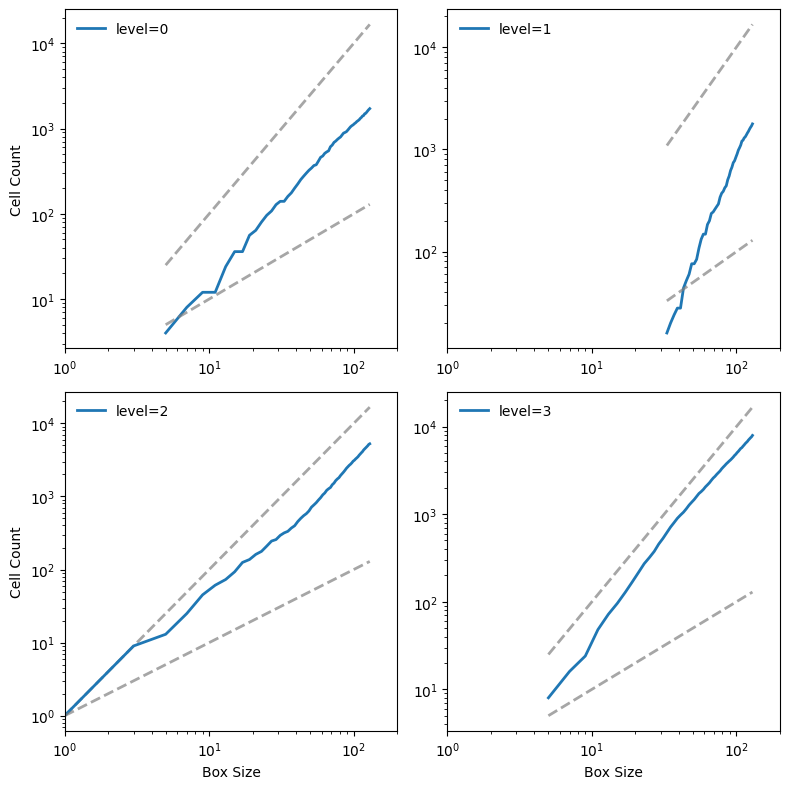

In [54]:
dims = box_count_four(pile3)

The lines are reasonably straight, which indicates that we are running the algorithm over a valid range of box sizes.  Here are the estimated slopes:

In [55]:
for i, dim in enumerate(dims):
    print('%d  %0.3f' % (i, dim))

0  1.871
1  3.502
2  1.781
3  2.084


The fractal dimensions for levels 0, 1, and 2 seem to be non-integer, which indicates that the image is fractal.

The fractal dimension for value 3 is indistinguishable from 2, but given the results for the other levels, the apparent curvature of the line, and the appearance of the pattern, it seems likely that it is also fractal.

## Exercise

Choose a different value of `n` and/or the initial `level` and run this analysis again.  Are the estimated fractal dimensions consistent?

# Spectral density

Suppose the sandpile made a little click each time a cell toppled.  What would it sound like?

`toppled_seq` contains the number of cells that toppled during each time step.  We can use Welch's algorithm to estimate its [power spectral density](https://en.wikipedia.org/wiki/Spectral_density).

In [56]:
signal = pile2.toppled_seq
len(signal)

1429764

In [57]:
from scipy.signal import welch

nperseg = 2048
freqs, powers = welch(signal, nperseg=nperseg, fs=nperseg)

The parameter nperseg specifies the number of time steps per segment. With longer segments, we can estimate the power for more frequencies. With shorter segments, we get better estimates for each frequency. The value, 2048, balances these tradeoffs.

And here's what it looks like.

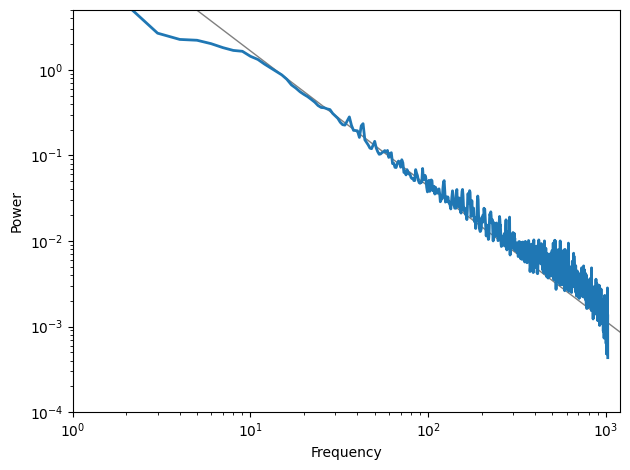

In [59]:
x = nperseg
ys = np.array([x**1.58, 1]) / 2.7e3
plt.plot([1, x], ys, color='gray', linewidth=1)

plt.plot(freqs, powers)
decorate(xlabel='Frequency',
         xscale='log',
         xlim=[1, 1200],
         ylabel='Power',
         yscale='log',
         ylim=[1e-4, 5])


The slope of the line is -1.58, which indicates that this spectrum is pink noise with parameter $\beta=1.58$.